## 这份代码在做什么  
你要预测加州房价（回归问题） 

Baseline：只用原始特征（例如收入、房间数、纬度经度…）训练 ANN  

Enhanced：在原始特征基础上，额外加一列**“邻居平均房价”**（用地理位置找附近的房子，把这些邻居的训练房价取平均），再训练 ANN  

最后比较两者的 Test MSE，看加邻域特征有没有让模型更准。


## 1. 导入库
numpy (np)：数学计算用的，尤其是 mean、数组索引等  
pandas (pd)：表格数据工具（DataFrame），像 Excel 那种结构  
matplotlib.pyplot (plt)：画图用（散点图、直线等）  

scikit-learn 这些：  
fetch_california_housing：下载/读取 California Housing 数据集（已经内置）  
train_test_split：把数据随机分成训练集/测试集  
StandardScaler：做标准化（让特征均值=0，方差=1），神经网络很需要这个  
MLPRegressor：前馈神经网络（ANN）做回归  
mean_squared_error：算 MSE（均方误差）  
NearestNeighbors：KNN 找最近的邻居（你用经纬度找附近地区）  

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors


## 2. 读取数据：X是特征，y是答案  
X：输入特征（每一行是一块区域的统计信息），比如：  
	•	MedInc（中位收入）  
	•	HouseAge（房龄）  
	•	AveRooms（平均房间数）  
	•	Latitude / Longitude（纬度经度）等等  

y：目标值（你要预测的真实房价标签），一个一维数组。


In [15]:
# Load data
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target  # median house value

## 3. 切分训练集/测试集。
test_size=0.2：20% 做测试集，80% 做训练集  
random_state=42：固定随机种子，保证你每次跑切分结果都一样（方便写报告、复现）。

#### 为什么要切分（split）  
因为你后面要做“邻居平均房价”这个特征，如果你不先 split，很容易把测试集的真实房价 y_test 偷偷用进来，这叫 data leakage（数据泄露），会让结果看起来特别好但其实作弊了。  

你现在的写法是正确的：  
✅ 先 split  
✅ 用训练集构造特征  
✅ 测试集只能“借用训练集的信息”，不能用测试集真实标签

In [16]:
# Train/test split (avoid leakage)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4.核心： 邻域特征add_graph_features  
#### 4.1 直觉理解  
房价强烈跟地理位置相关：  
你住伦敦一区，隔壁一区差不多也贵；你住郊区，隔壁郊区也差不多便宜。  
所以我们给每一条数据加一个新特征：  
Avg_Neighbor_Price = “附近 k 个邻居的平均房价”  
这样神经网络不需要自己从经纬度“猜”空间规律，我们直接把空间规律喂给它。  

#### 4.2 函数代码讲解  
见代码  

#### * 为什么要k+1  
当你给训练集加特征时：df 和 reference_df 是同一个集合。  
那 KNN 找最近邻时，第一个邻居往往就是它自己（距离=0）。  
如果你不排除它自己，那么：  
Avg_Neighbor_Price = mean( [自己的y, 邻居1的y, 邻居2的y, …] )  
这会让新特征更像“答案本身”，会让 enhanced 的效果“看起来更强”（偏虚高）。  
所以我们做：  
	•	先找 k+1 个邻居  
	•	把第一个（自己）丢掉  
	•	剩下 k 个再平均  



In [17]:
def add_graph_features(df, reference_df, reference_y, k=5, exclude_self=False):
# df：你要给谁加特征（可能是训练集，也可能是测试集）
# reference_df：你用谁来当“邻居候选池”
# reference_y：邻居候选池对应的真实房价（只能是训练集的 y）
# k=5：找 5 个最近邻
# exclude_self：是否把“自己”从邻居里排除（只对训练集需要）

    # Coordinates for neighbor search 取经纬度
    coords_ref = reference_df[['Latitude', 'Longitude']]
    coords_target = df[['Latitude', 'Longitude']]

    # If excluding self, grab one extra neighbor then drop the first one 排除自己
    n_neighbors = k + 1 if exclude_self else k

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(coords_ref)  #fit(coords_ref)：告诉 KNN，邻居候选点都在这里
    distances, indices = nbrs.kneighbors(coords_target)  #对每个目标点找最近邻返回距离和邻居在 reference_df 里的行号索引

    neighbor_prices = []
    for idx_list in indices:
        if exclude_self:
            # Drop the closest neighbor (usually itself when df == reference_df)
            idx_list = idx_list[1:]
        neighbor_prices.append(np.mean(reference_y[idx_list]))  #np.mean(...)求平均

    new_df = df.copy()  #把这个新特征加到df里
    new_df['Avg_Neighbor_Price'] = neighbor_prices
    return new_df

#### 4.3 用add_graph_features函数生成enhanced数据  
关键点：  
训练集 enhanced：邻居来自训练集本身，但排除自己（exclude_self=True）  
测试集 enhanced：邻居只能来自训练集（reference_df = X_train_raw, reference_y = y_train）  
✅ 不使用 y_test（避免泄露）

In [18]:
# Enhanced datasets
# - training enhanced excludes self
X_train_enhanced = add_graph_features(
    X_train_raw, X_train_raw, y_train, k=5, exclude_self=True
)
# - test enhanced uses ONLY training as reference (no leakage)
X_test_enhanced = add_graph_features(
    X_test_raw, X_train_raw, y_train, k=5, exclude_self=False
)

## 5. 定义神经网络：为什么抽成 build_mode  
这样做的意义：  
Baseline 和 Enhanced 用一模一样的网络结构，差异只来自“有没有邻域特征”。
这叫 fair comparison（公平比较）。 

参数解释：  
	•	hidden_layer_sizes=(64,32)：两层隐藏层  
	•	第一层 64 个神经元  
	•	第二层 32 个神经元  
	•	activation='relu'：激活函数 ReLU（非线性，神经网络的灵魂）  
	•	solver='adam'：优化器（训练时怎么更新参数）  
	•	alpha=1e-4：L2 正则化强度（防止过拟合的一点点约束）  
	•	max_iter=500：最多训练 500 次迭代  
	•	random_state=42：固定初始化随机性



In [19]:
#Model definition helper (same architecture for fair comparison)
def build_model(random_state=42):
    return MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        max_iter=500,
        random_state=random_state
    )

## 6.Baseline：不加邻域特征，直接训练 ANN  

#### 6.1 标准化（重要）
为什么要标准化？  
神经网络训练是靠梯度下降，如果某个特征数值范围很大（比如收入 10100），另一个很小（比如经纬度 3040），训练会很不稳定、收敛慢、甚至效果差。  

关键点：  
	•	fit_transform 只对训练集做（学习均值方差并转换）  
	•	测试集只能 transform（用训练集的均值方差来变换）  
	•	✅ 这也是避免泄露（不能用测试集统计量）


In [20]:
# BASELINE: train ANN on original X (no graph features)
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_raw)
X_test_base_scaled = scaler_base.transform(X_test_raw)

#### 6.2 训练 + 预测 + MSE  
•fit：训练模型（学参数）  
•predict：预测测试集房价  
•MSE：衡量误差大小  
•越小越好  
•MSE 是平均平方误差：错误大的会被平方惩罚更重   


In [21]:
model_base = build_model(random_state=42)
model_base.fit(X_train_base_scaled, y_train)

y_pred_base = model_base.predict(X_test_base_scaled)
mse_base = mean_squared_error(y_test, y_pred_base)

## 7. Enhanced：加了 Avg_Neighbor_Price 再训练 ANN  
这一段和 baseline 完全同样流程，只是输入特征变成 X_train_enhanced / X_test_enhanced  

这里为什么要单独一个 scaler_enh？  
因为 enhanced 多了一列特征，维度不一样；不能用 baseline 的 scaler。

In [22]:
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enhanced)
X_test_enh_scaled = scaler_enh.transform(X_test_enhanced)

model_enh = build_model(random_state=42)
model_enh.fit(X_train_enh_scaled, y_train)

y_pred_enh = model_enh.predict(X_test_enh_scaled)
mse_enh = mean_squared_error(y_test, y_pred_enh)

## 8. 对比结果： MSE和提升百分比  
如果 enhanced 更好：mse_enh 更小 → improvement 是正数（提升%）  
如果 enhanced 更差：improvement 是负数（退步%）


In [23]:
improvement = (mse_base - mse_enh) / mse_base * 100

results = pd.DataFrame({
    "Model": ["Baseline (no graph feature)", "Enhanced (+Avg_Neighbor_Price)"],
    "Test MSE": [mse_base, mse_enh]
})

print(results)
print(f"\nRelative MSE improvement: {improvement:.2f}% (positive means enhanced is better)")


                            Model  Test MSE
0     Baseline (no graph feature)  0.274289
1  Enhanced (+Avg_Neighbor_Price)  0.180995

Relative MSE improvement: 34.01% (positive means enhanced is better)


## 9. 可视化：Actual vs Predicted 散点图看拟合质量
•	x轴：真实房价（Actual）  
•	y轴：预测房价（Predicted）  
•	红色虚线：理想情况 y=x（预测=真实）  
•	点越贴近红线 → 预测越准  
•	如果点整体偏离、或者形成弯曲 → 模型有系统性偏差  

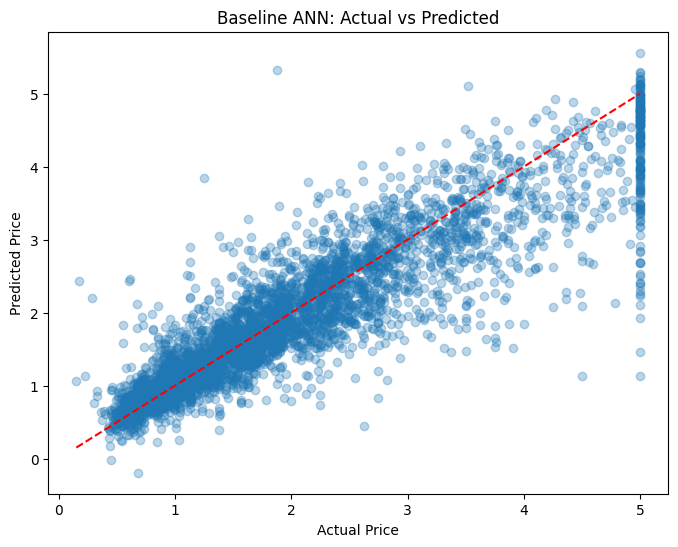

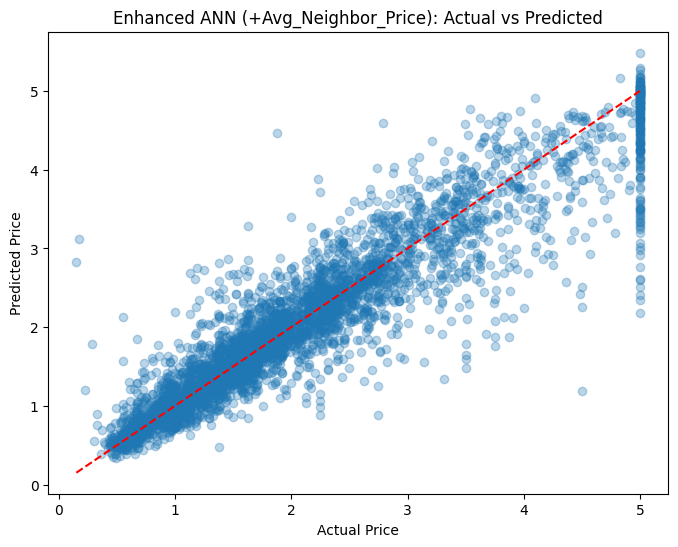

In [24]:
# Visualize (Actual vs Predicted)
def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    # identity line
    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(title)
    plt.show()

plot_actual_vs_pred(y_test, y_pred_base, "Baseline ANN: Actual vs Predicted")
plot_actual_vs_pred(y_test, y_pred_enh, "Enhanced ANN (+Avg_Neighbor_Price): Actual vs Predicted")

In [25]:
cap = 5.0
print("Proportion capped at 5:", np.mean(y_test == cap))

mask_cap = (y_test == 5.0)
mse_cap = mean_squared_error(y_test[mask_cap], y_pred_enh[mask_cap])
mse_noncap = mean_squared_error(y_test[~mask_cap], y_pred_enh[~mask_cap])
print("MSE (capped=5):", mse_cap)
print("MSE (non-capped):", mse_noncap)

Proportion capped at 5: 0.0012112403100775194
MSE (capped=5): 0.7759795175929758
MSE (non-capped): 0.1802738656361963


A noticeable vertical band at Actual = 5 indicates that the target variable is capped at 5 for a subset of observations. This censoring limits the model’s ability to learn fine-grained differences among the most expensive areas. In our test set, ___% of samples are capped at 5, and the prediction error on capped samples (MSE = ___) is substantially larger than on non-capped samples (MSE = ___). Therefore, while overall performance improves with the neighbourhood feature, predictions at the upper end remain challenging due to target censoring.